In [1]:
using Pkg
if isfile("../Project.toml") && isfile("../Manifest.toml")
    Pkg.activate("..");
end

function printer(x::Any, verbose="")
    if verbose != ""
        println(verbose)
    end
    show(stdout, "text/plain", x)
    println("")
end

 Activating environment at `~/Programming/julia/notebook/JuliaProbo/Project.toml`


printer (generic function with 2 methods)

In [2]:
using CSV, DataFrames, Plots, Statistics, StatsBase, Random, Distributions, LinearAlgebra
gr();

In [3]:
abstract type Object end
abstract type Sensor end
mutable struct Agent <: Object
    v_::Float64
    ω_::Float64
    function Agent(v::Float64, ω::Float64)
        new(v, ω)
    end
end
function decision(agent::Agent, observation=nothing)
    return agent.v_, agent.ω_
end
mutable struct IdealRobot <: Object
    pose_::Array{Float64, 1}
    agent_::Agent
    radius_::Float64
    color_::String
    poses_::Array{Array{Float64, 1}, 1}
    sensor_::Sensor
    function IdealRobot(pose::AbstractArray{Float64, 1}, agent::Agent, sensor::Sensor, radius=0.2, color="blue")
        new([pose[1], pose[2], pose[3]], agent, radius, color, [copy(pose)], sensor)
    end
end
function draw(robot::IdealRobot, p)
    p = scatter!([robot.pose_[1]], [robot.pose_[2]], markersize=robot.radius_ * 100, color=robot.color_, markeralpha=0.5, legend=nothing, aspect_ratio=:equal)
    θ = robot.pose_[3]
    p = quiver!([robot.pose_[1]], [robot.pose_[2]], quiver=([robot.radius_ * cos(θ) * 5], [robot.radius_ * sin(θ) * 5]), color="black")
    x_his = [pose[1] for pose in robot.poses_]
    y_his = [pose[2] for pose in robot.poses_]
    p = plot!(x_his, y_his, color="black", lw=0.5)
end
function state_transition(robot::IdealRobot, v::Float64, ω::Float64, dt::Float64)
    θ = robot.pose_[3]
    new_pose = [0.0, 0.0, 0.0]
    if abs(ω) < 1e-10
        dpose = [v * cos(θ), v * sin(θ), ω] * dt
        new_pose = robot.pose_ .+ dpose
    else
        dpose = [v / ω * ( sin(θ + ω * dt) - sin(θ)), v / ω * ( -cos(θ + ω * dt) + cos(θ)), ω * dt]
        new_pose = robot.pose_ .+ dpose
    end
    push!(robot.poses_, robot.pose_)
    robot.pose_ = copy(new_pose)
    return new_pose
end
mutable struct World
    objects_::Array{Object, 1}
    xlim_::Array{Float64, 1}
    ylim_::Array{Float64, 1}
    debug_::Bool
    function World(xlim::AbstractArray{Float64, 1}, ylim::AbstractArray{Float64, 1}, debug=false)
        new(Array{Any, 1}[], [xlim[1], xlim[2]], [ylim[1], ylim[2]], debug)
    end
end

function Base.push!(world::World, obj::Object)
    push!(world.objects_, obj)
end

function draw(world::World, annota=nothing)
    p = plot(aspect_ratio=:equal, xlim=world.xlim_, ylim=world.ylim_)
    xpos = (world.xlim_[1] + world.xlim_[2]) / 2.0
    ypos = world.ylim_[2] - 0.1 * (world.ylim_[2] - world.ylim_[1])
    if annota != nothing
        p = annotate!(xpos, ypos, annota)
    end
    for obj = world.objects_
        draw(obj, p)
    end
    return p
end

draw (generic function with 3 methods)

In [4]:
struct Landmark <: Object
    pos::Array{Float64, 1}
    id::Int64
    function Landmark(pos::AbstractArray{Float64, 1}, id::Int64)
        new(pos, id)
    end
end
function draw(mark::Landmark, p)
    p = scatter!([mark.pos[1]], [mark.pos[2]], markershape=:star, markersize=10, color="orange")
    p = annotate!(mark.pos[1] + 0.5, mark.pos[2] + 0.5, text("id: $(mark.id)", 10))
end

draw (generic function with 4 methods)

In [5]:
mutable struct Map <: Object
    landmarks_::Array{Landmark, 1}
    function Map()
        new(Array{Landmark, 1}[])
    end
end
function Base.push!(map::Map, landmark::Landmark)
    push!(map.landmarks_, landmark)
end
function Base.push!(map::Map, landmarks::AbstractArray{Landmark, 1})
    for landmark = landmarks
        push!(map.landmarks_, landmark)
    end
end
function draw(map::Map, p)
    for landmark = map.landmarks_
        draw(landmark, p)
    end
end

draw (generic function with 5 methods)

In [9]:
mutable struct IdealCamera <: Sensor
    map_::Array{Landmark, 1}
    last_observation_::Array{Array{Float64, 1}, 1}
    distance_range::Array{Float64, 1}
    direction_range::Array{Float64, 1}
    function IdealCamera(map::Array{Landmark, 1}, distance_range=[0.5, 6.0], direction_range=[-pi/3, pi/3])
        new(map, Array{Array{Float64, 1}, 1}[], distance_range, direction_range)
    end
end
function visible(camera::IdealCamera, polarpos::AbstractArray{Float64, 1}=nothing)
    if polarpos == nothing
        return false
    else
        return camera.distance_range[1] <= polarpos[1] <= camera.distance_range[2] &&
        camera.direction_range[1] <= polarpos[2] <= camera.direction_range[2]
    end
end
function observation_function(camera_pose::AbstractArray{Float64, 1}, landmark_pos::AbstractArray{Float64, 1})
    diff = landmark_pos .- camera_pose[1:2]
    ϕ = atan(diff[2], diff[1]) - camera_pose[3]
    while ϕ >= pi; ϕ -= 2 * pi end
    while ϕ < -pi; ϕ += 2 * pi end
    return [hypot(sum(diff .* diff)), ϕ]
end
function observations(camera::IdealCamera, camera_pose::AbstractArray{Float64, 1})
    n = size(camera.map_)[1]
    observed = Array{Array{Float64, 1}, 1}[]
    for i in 1:n
        if visible(camera, z)
            z = observation_function(camera_pose, landmark.pos)
            push!(observed, copy(z))
        end
    end
    camera.last_observation_ = copy(observed)
    return observed
end
function draw(camera::IdealCamera, camera_pose::AbstractArray{Float64, 1}, p)
    for obsv = camera.last_observation_
        x, y, θ = camera_pose
        distance, direction = obsv[1], obsv[2]
        lx = x + distance * cos(direction + θ)
        ly = y + distance * sin(direction * θ)
        p = plot!([x, lx], [y, ly], color="pink")
    end
end

draw (generic function with 6 methods)

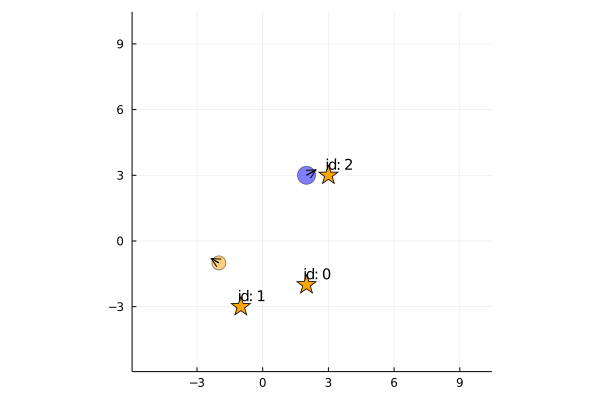

In [11]:
straight_agent = Agent(0.2, 0.0)
circling_agent = Agent(0.2, 10.0 / 180.0 * pi)
landmarks = [Landmark([2.0, -2.0], 0), Landmark([-1.0, -3.0], 1), Landmark([3.0, 3.0], 2)]
m = Map()
push!(m, landmarks)
robot1 = IdealRobot([2.0, 3.0, pi/6], straight_agent, IdealCamera(landmarks), 0.1, "blue",)
robot2 = IdealRobot([-2.0, -1.0, pi*5/6], circling_agent, IdealCamera(landmarks), 0.08, "orange")
xlim = [-5.5, 10]
ylim = [-5.5, 10]
world = World(xlim, ylim)
push!(world, robot1)
push!(world, robot2)
push!(world, m)
p = draw(world)
plot(p)